In [15]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


### Imports and Configuration

In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from transformers import TrainingArguments, Trainer
import torch
from pathlib import Path
from sklearn.linear_model import LogisticRegression

from introdl.utils import config_paths_keys

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys(env_path='../Course_Tools/mac.env')
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

# for just this lesson
LESSON_DATA_PATH = Path('./data').resolve()
data_path = LESSON_DATA_PATH / 'IT_tickets_classify.csv'

2025-01-10 21:20:19.292964: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 21:20:19.925748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736544020.170251     228 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736544020.250772     228 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 21:20:20.816953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

MODELS_PATH=/home/user/home_workspace/models
DATA_PATH=/home/user/home_workspace/data
TORCH_HOME=/home/user/home_workspace/downloads
HF_HOME=/home/user/home_workspace/downloads


### Load and Visualize Data

In [26]:
data_path = Path('./data/IT_tickets_classify.csv').resolve() 
df = pd.read_csv(data_path)

print(f'This dataset has {df.shape[0]} IT tickets')

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

This dataset has 47837 IT tickets


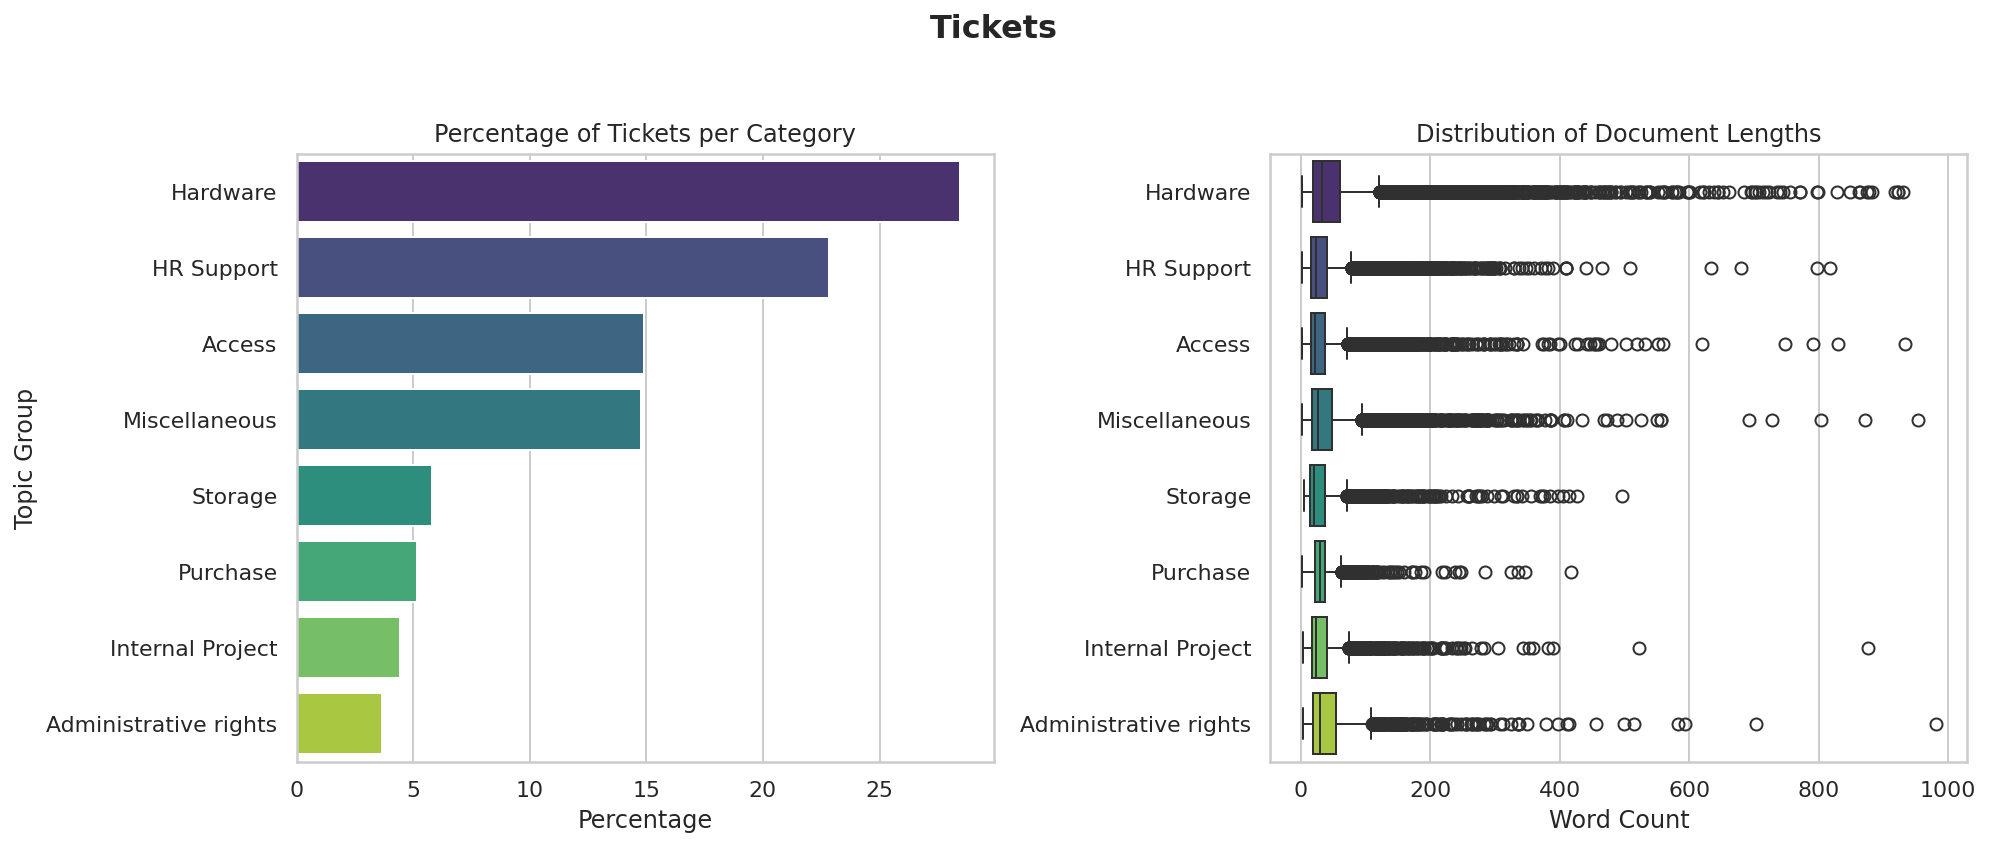

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate percentages per category
category_counts = df["Topic_group"].value_counts(normalize=True) * 100
category_percentages = category_counts.reset_index()
category_percentages.columns = ["Topic_group", "Percentage"]

# Calculate lengths of documents as word count
df["Document_Length"] = df["Document"].apply(lambda x: len(x.split()))

# Get the order of categories from the barplot data
category_order = category_percentages["Topic_group"]

# Create a consistent color palette
palette = sns.color_palette("viridis", len(category_order))
color_mapping = dict(zip(category_order, palette))

# Create the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Barplot: Percentage per category
sns.barplot(
    data=category_percentages,
    x="Percentage",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[0]
)
axes[0].set_title("Percentage of Tickets per Category")
axes[0].set_xlabel("Percentage")
axes[0].set_ylabel("Topic Group")

# Boxplot: Distribution of document lengths
sns.boxplot(
    data=df,
    x="Document_Length",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[1]
)
axes[1].set_title("Distribution of Document Lengths")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("")

# Set the suptitle
fig.suptitle("Tickets", fontsize=16, weight="bold")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Prepare the data

Split the data and build mappings from text labels to integers and vice versa.

In [28]:
test_size=0.2
random_state=42

"""Split data into train and test sets, and map labels to integers."""
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integers
unique_labels = list(set(train_labels + test_labels))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

train_labels = [label_to_id[label] for label in train_labels]
test_labels = [label_to_id[label] for label in test_labels]

### Compute TFIDF Feature Vectors

### What Are TF-IDF Vectors?

TF-IDF (Term Frequency-Inverse Document Frequency) vectors are a statistical representation of text data that capture the importance of terms within a document relative to a collection of documents (the corpus). This method assigns a weight to each term based on its frequency in a specific document (term frequency, TF) and how common or rare it is across all documents in the corpus (inverse document frequency, IDF). The result is a sparse, numerical vector for each document, where each dimension corresponds to a unique term in the vocabulary. TF-IDF is widely used in text mining, natural language processing, and machine learning as a feature extraction technique for tasks like classification, clustering, and information retrieval. However, as the size of the vocabulary grows, the dimensionality of the TF-IDF vectors increases, potentially leading to computational inefficiencies and the curse of dimensionality.

---

### Tricks for Limiting Dimensionality

To address the high dimensionality of TF-IDF vectors, several preprocessing techniques can be applied to reduce the vocabulary size while retaining the most meaningful terms. **Stemming** is one such method, where words are reduced to their root forms (e.g., "running" → "run"), grouping related words into a single term and thereby reducing the vocabulary size. Similarly, **lemmatization** refines this process by considering the context and part of speech to produce base forms. Removing **stopwords** like "the," "is," and "and" eliminates common, less informative terms that appear frequently across documents. Setting thresholds for **minimum and maximum document frequency** (e.g., `min_df` and `max_df`) ensures that terms appearing in very few documents or nearly all documents are excluded from the vocabulary. Additionally, limiting the vocabulary size directly with `max_features` retains only the top terms with the highest importance scores. Finally, incorporating **n-grams** (e.g., bigrams and trigrams) helps capture multi-word phrases, adding context while keeping the range limited to prevent explosive growth in dimensionality. Combining these techniques creates a more compact, computationally efficient representation of text data while preserving its semantic richness.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from scipy.sparse import csr_matrix

# Download NLTK resources
nltk.download('punkt')

# Custom tokenizer with stemming
def stemming_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    return [stemmer.stem(token) for token in tokens]

def generate_tfidf_vectors(texts):
    """
    Generates a sparse TF-IDF matrix for a list of input strings with stemming and dimensionality reduction.

    Args:
        texts (list of str): List of strings, where each string represents a text.

    Returns:
        scipy.sparse.csr_matrix: Sparse TF-IDF matrix.
        TfidfVectorizer: The fitted TF-IDF vectorizer.
    """
    # Initialize the TfidfVectorizer with preprocessing and dimensionality reduction options
    tfidf_vectorizer = TfidfVectorizer(
        tokenizer=stemming_tokenizer,  # Use stemming tokenizer
        stop_words='english',  # Remove common English stopwords
        min_df=2,  # Remove rare terms (appear in fewer than 2 documents)
        max_df=0.85,  # Remove overly common terms (appear in more than 85% of documents)
        max_features=1000,  # Limit vocabulary size to top 1000 terms
        ngram_range=(1, 2)  # Include unigrams and bigrams
    )
    
    # Fit the vectorizer and transform the input texts
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    
    return tfidf_matrix, tfidf_vectorizer

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
train_features, vectorizer = generate_tfidf_vectors(train_texts)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

In [42]:
train_features

<38269x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 995328 stored elements in Compressed Sparse Row format>

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def train_and_validate_model(train_features, train_labels, test_features, test_labels, id_to_labels):
    """
    Trains a logistic regression model, validates it on the test set, computes metrics,
    displays a confusion matrix, and returns a DataFrame with test labels and predictions.

    Args:
        train_features: Features for training the model (e.g., sparse matrix or dense array).
        train_labels: List or array of integer labels for the training data.
        test_features: Features for testing the model.
        test_labels: List or array of integer labels for the testing data.
        id_to_labels: Dictionary mapping integer labels to their original string labels.

    Returns:
        pd.DataFrame: A DataFrame containing test labels and predictions with original string labels.
    """
    # Initialize and fit the logistic regression model
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(train_features, train_labels)

    # Make predictions on the test set
    test_predictions = model.predict(test_features)

    # Convert integer labels to string labels for the test set and predictions
    test_labels_str = [id_to_labels[label] for label in test_labels]
    predictions_str = [id_to_labels[label] for label in test_predictions]

    # Compute classification metrics
    print("Classification Report:")
    print(classification_report(test_labels_str, predictions_str))

    # Compute and display the confusion matrix
    cm = confusion_matrix(test_labels_str, predictions_str, labels=list(id_to_labels.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_labels.values()))
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    disp.ax_.set_title("Confusion Matrix")
    
    # Create and return a DataFrame with test labels and predictions
    results_df = pd.DataFrame({
        "Test Labels": test_labels_str,
        "Predictions": predictions_str
    })

    return results_df

# Example Usage
# Assuming train_features, train_labels, test_features, test_labels, and id_to_labels are defined
# results_df = train_and_validate_model(train_features, train_labels, test_features, test_labels, id_to_labels)
# print(results_df)


Classification Report:
                       precision    recall  f1-score   support

               Access       0.91      0.86      0.88      1455
Administrative rights       0.88      0.67      0.76       342
           HR Support       0.81      0.83      0.82      2107
             Hardware       0.79      0.85      0.82      2760
     Internal Project       0.90      0.78      0.84       451
        Miscellaneous       0.79      0.82      0.80      1400
             Purchase       0.96      0.87      0.91       497
              Storage       0.93      0.85      0.88       556

             accuracy                           0.83      9568
            macro avg       0.87      0.82      0.84      9568
         weighted avg       0.84      0.83      0.83      9568



  Test Labels Predictions
0    Hardware    Hardware
1    Purchase    Purchase
2    Hardware    Hardware
3  HR Support  HR Support
4    Hardware    Hardware


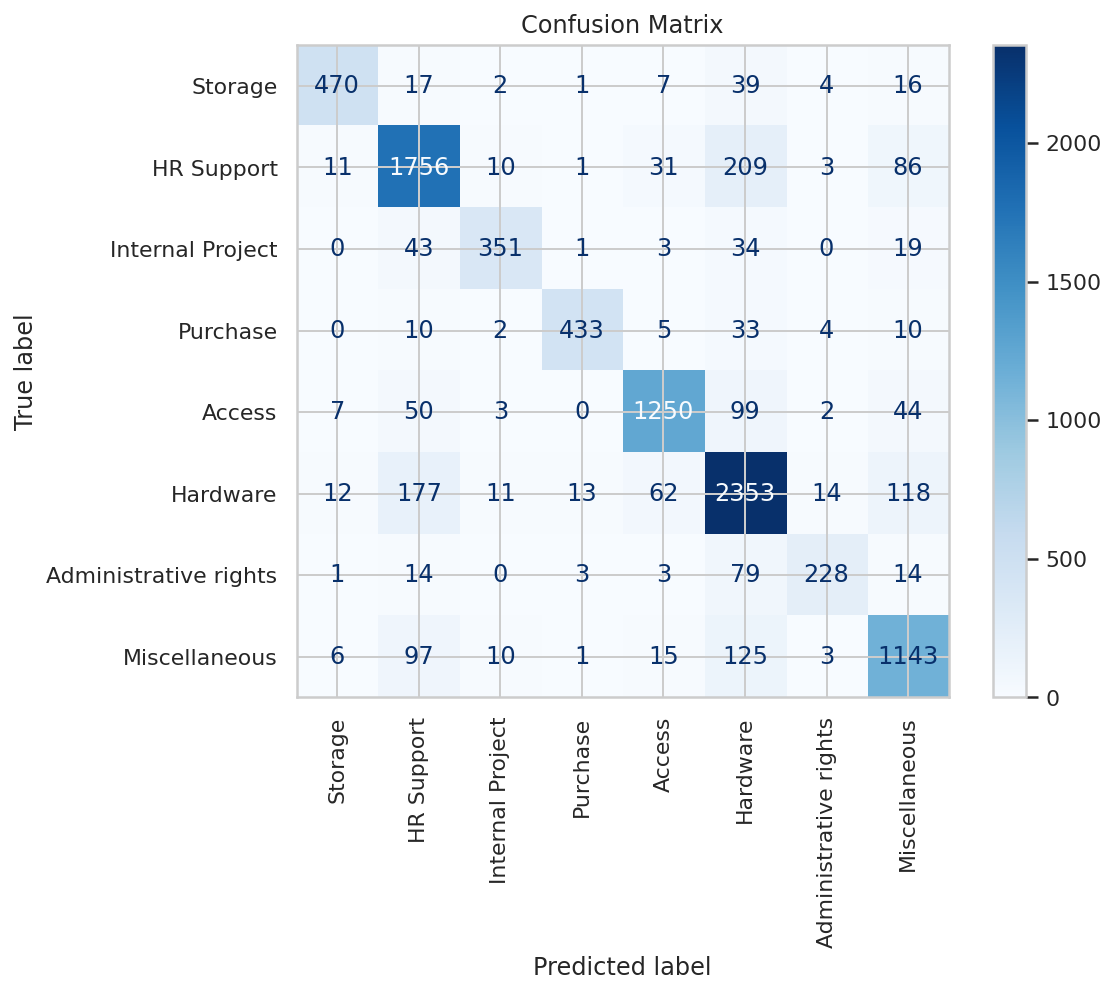

In [44]:
test_features = vectorizer.transform(test_texts)

# Example Usage
# Assuming train_features, train_labels, test_features, test_labels, and id_to_labels are defined
results_df = train_and_validate_model(train_features, train_labels, test_features, test_labels, id_to_label)
print(results_df.head())


In [2]:
# Helper Functions

def load_dataframe(data_path):
    """Load the dataframe from a CSV file."""
    return pd.read_csv(data_path)

def prepare_data(df, test_size=0.2, random_state=42):
    """Split data into train and test sets, and map labels to integers."""
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
    )

    # Map labels to integers
    unique_labels = list(set(train_labels + test_labels))
    label_to_id = {label: i for i, label in enumerate(unique_labels)}
    id_to_label = {i: label for label, i in label_to_id.items()}

    train_labels = [label_to_id[label] for label in train_labels]
    test_labels = [label_to_id[label] for label in test_labels]

    return train_texts, test_texts, train_labels, test_labels, label_to_id, id_to_label

def visualize_data(df):
    """Visualize the data with barplots of percentages and boxplots of document lengths."""
    # Calculate percentages per category
    category_counts = df["Topic_group"].value_counts(normalize=True) * 100
    category_percentages = category_counts.reset_index()
    category_percentages.columns = ["Topic_group", "Percentage"]

    # Calculate lengths of documents
    df["Document_Length"] = df["Document"].apply(len)

    # Create the side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Barplot: Percentage per category
    sns.barplot(
        data=category_percentages,
        x="Percentage",
        y="Topic_group",
        palette="viridis",
        ax=axes[0]
    )
    axes[0].set_title("Percentage of Tickets per Category")
    axes[0].set_xlabel("Percentage")
    axes[0].set_ylabel("Topic Group")

    # Boxplot: Distribution of document lengths
    sns.boxplot(
        data=df,
        x="Document_Length",
        y="Topic_group",
        palette="viridis",
        ax=axes[1]
    )
    axes[1].set_title("Distribution of Document Lengths")
    axes[1].set_xlabel("Document Length")
    axes[1].set_ylabel("")

    # Set the suptitle
    fig.suptitle("Tickets", fontsize=16, weight="bold")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def tokenize_dataset(tokenizer, texts, labels):
    """Tokenize the dataset."""
    dataset = Dataset.from_dict({"text": texts, "label": labels})
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True)
    return tokenized_dataset

def compute_metrics(pred):
    """Compute evaluation metrics."""
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def plot_confusion_matrix(y_true, y_pred, id_to_label, title="Confusion Matrix"):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    labels = [id_to_label[i] for i in range(len(id_to_label))]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<ipython-input-2-3194e8057996>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-2-3194e8057996>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


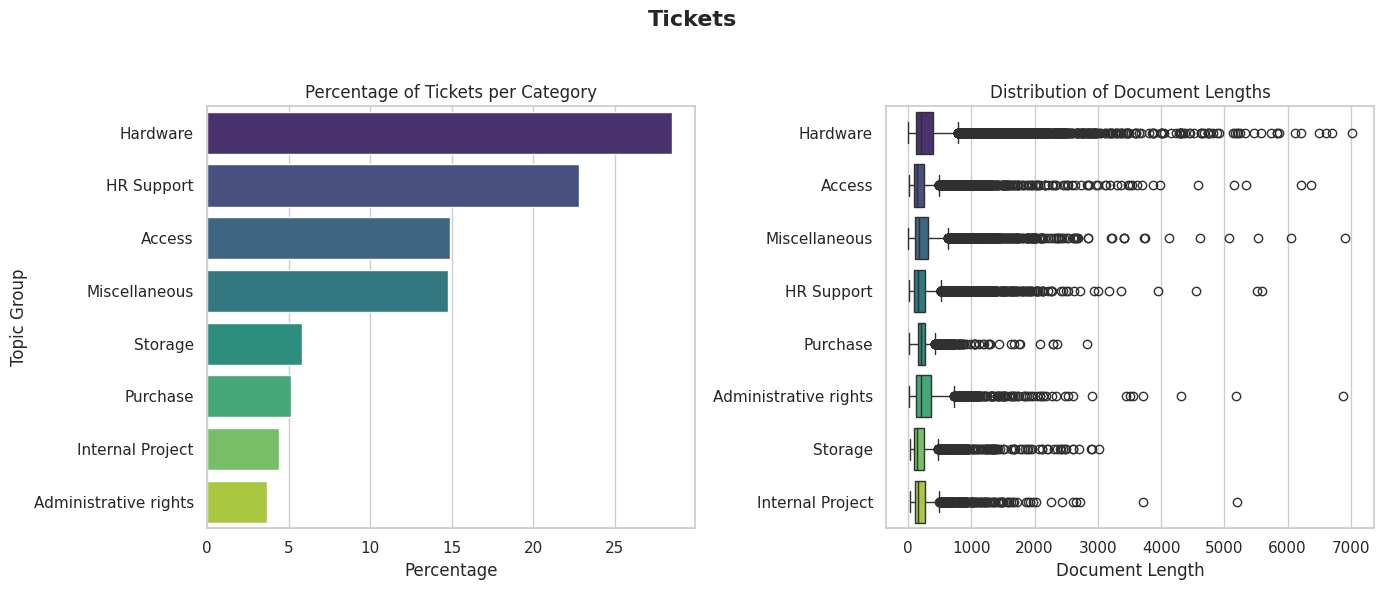

In [3]:
# Load Pre-trained Model and Tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Paths and Data Preparation
data_path = "./data/IT_tickets_classify.csv"  # Replace with the actual path to your CSV
df = load_dataframe(data_path)
visualize_data(df)


In [4]:

train_texts, test_texts, train_labels, test_labels, label_to_id, id_to_label = prepare_data(df)


In [9]:
def feature_extract_and_classify(use_xgboost=True):
    """
    Extract features using a frozen DistilBERT model and classify using either XGBoost or Logistic Regression.
    
    Args:
        use_xgboost (bool): If True, use XGBoost for classification; otherwise, use Logistic Regression.
    """
    model = AutoModel.from_pretrained(model_checkpoint).to(device)
    model.eval()  # Set model to evaluation mode

    # Paths for saving and loading features
    train_features_path = DATA_PATH / "train_features.npy"
    test_features_path = DATA_PATH / "test_features.npy"

    # Check if features already exist
    if train_features_path.exists() and test_features_path.exists():
        print("Loading extracted features from files...")
        train_features = np.load(train_features_path)
        test_features = np.load(test_features_path)
    else:
        def extract_features(texts):
            """Extract class token features."""
            inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract [CLS] token representation

        print("Extracting features from training data...")
        train_features = np.vstack([
            extract_features(train_texts[i:i + 16]) for i in range(0, len(train_texts), 16)
        ])

        print("Extracting features from testing data...")
        test_features = np.vstack([
            extract_features(test_texts[i:i + 16]) for i in range(0, len(test_texts), 16)
        ])

        # Save features to disk
        print("Saving extracted features to disk...")
        np.save(train_features_path, train_features)
        np.save(test_features_path, test_features)

    # Classifier selection
    if use_xgboost:
        print("Training XGBoost classifier...")
        xgb_clf = XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            tree_method="gpu_hist" if torch.cuda.is_available() else "hist"  # Use GPU if available
        )
        xgb_clf.fit(train_features, train_labels)
        print("Evaluating XGBoost classifier...")
        test_predictions = xgb_clf.predict(test_features)
    else:
        print("Training Logistic Regression classifier...")
        log_reg_clf = LogisticRegression(max_iter=1000)
        log_reg_clf.fit(train_features, train_labels)
        print("Evaluating Logistic Regression classifier...")
        test_predictions = log_reg_clf.predict(test_features)

    # Metrics and Confusion Matrix
    acc = accuracy_score(test_labels, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average="weighted")
    print("Classification Metrics:", {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1})

    plot_confusion_matrix(test_labels, test_predictions, id_to_label, 
                          title="Confusion Matrix - XGBoost" if use_xgboost else "Confusion Matrix - Logistic Regression")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


Using device: cuda
Running Feature Extraction with Logistic Regression...


Loading extracted features from files...
Training Logistic Regression classifier...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression classifier...
Classification Metrics: {'accuracy': 0.7566889632107023, 'precision': 0.7587012760327658, 'recall': 0.7566889632107023, 'f1': 0.7567730478087057}


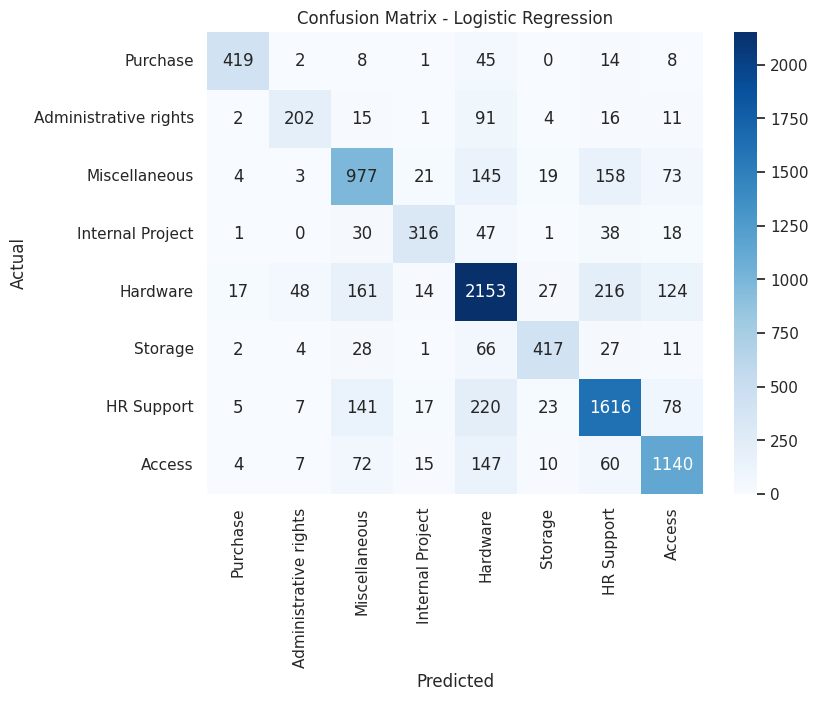

In [10]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Running Feature Extraction with Logistic Regression...")
xgboost_metrics = feature_extract_and_classify(use_xgboost=False)

In [6]:
# Tokenize datasets
tokenized_train = tokenize_dataset(tokenizer, train_texts, train_labels)
tokenized_test = tokenize_dataset(tokenizer, test_texts, test_labels)

batch_size = 32

models_and_logs_dir = MODELS_PATH / 'L08_fine_tune_distilbert'


Map:   0%|          | 0/38269 [00:00<?, ? examples/s]

Map:   0%|          | 0/9568 [00:00<?, ? examples/s]

In [7]:
def fine_tune_model(resume_from_checkpoint=False):
    """
    Fine-tune the DistilBERT model and evaluate.

    Args:
        resume_from_checkpoint (bool): If True, resumes training from the last checkpoint if available.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_to_id)).to(device)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir=models_and_logs_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=4,
        weight_decay=0.01,
        fp16=True,
        logging_dir=models_and_logs_dir / "logs",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=1,
        logging_steps=10
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Check for the latest checkpoint if resume_from_checkpoint is True
    checkpoint = None
    if resume_from_checkpoint:
        checkpoints = sorted(models_and_logs_dir.glob("checkpoint-*"), key=lambda x: int(x.name.split("-")[-1]))
        if checkpoints:
            checkpoint = str(checkpoints[-1])
            print(f"Resuming training from checkpoint: {checkpoint}")
        else:
            print("No checkpoint found. Starting training from scratch.")

    print("Starting fine-tuning...")
    ouput = trainer.train(resume_from_checkpoint=checkpoint)

    # Save the model to the specified path
    #save_path = MODELS_PATH / 'distilbert_it_classify_finetuned.pth'
    #print(f"Saving fine-tuned model to {save_path}...")
    #torch.save(model.state_dict(), save_path)

    #print("Evaluating fine-tuned model...")
    #metrics = trainer.evaluate()
    #print("Fine-Tuning Metrics:", metrics)

    # Predictions and Confusion Matrix
    print("Generating predictions...")
    predictions = trainer.predict(tokenized_test)
    plot_confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=1), id_to_label, 
                          title="Confusion Matrix - Fine-Tuning")
    
    print("Final Evaluation Metrics")
    print(trainer.state.log_history[-1])
    return metrics, trainer, output


Using device: cuda

Running Fine-Tuning Approach...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Resuming training from checkpoint: /home/user/cs_workspace/models/L08_fine_tune_distilbert/checkpoint-2392
Starting fine-tuning...


/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = torch.load(rng_file)


Epoch,Training Loss,Validation Loss


Generating predictions...


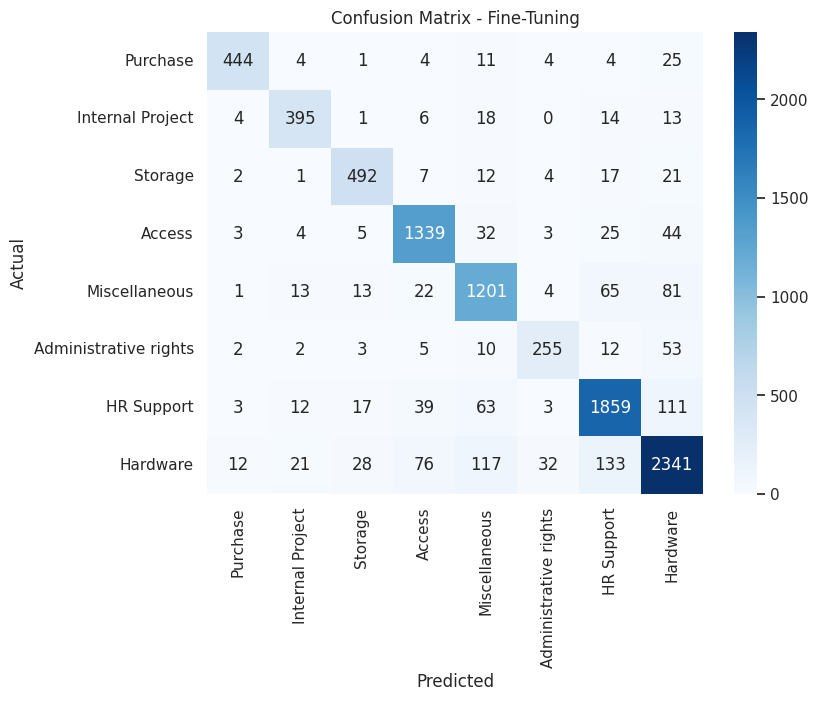

Final Evaluation Metrics
{'train_runtime': 1126.5799, 'train_samples_per_second': 135.877, 'train_steps_per_second': 4.246, 'total_flos': 2.0279749247729664e+16, 'train_loss': 0.1860434776514669, 'epoch': 4.0, 'step': 4784}


NameError: name 'metrics' is not defined

In [8]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("\nRunning Fine-Tuning Approach...")
fine_tune_metrics, trainer, output = fine_tune_model(resume_from_checkpoint=True)


In [14]:
trainer.state.log_history[-5:]

NameError: name 'trainer' is not defined